Check the tensorflow version

In [1]:
import tensorflow as tf 
print(tf.__version__) 

2.2.0-rc2


Import all neceassry libraries

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D,Conv2DTranspose, UpSampling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile
import random
import shutil
from shutil import copyfile
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


Obtain the Dataset

In [3]:
#shutil.rmtree('/tmp/Task.zip')
!wget --no-check-certificate \
"https://codeload.github.com/SukhpreetKhangura/Task/zip/master" \
    -O "/tmp/Task.zip"

zip_ref = zipfile.ZipFile("/tmp/Task.zip", 'r')
zip_ref.extractall("/tmp/Task")
zip_ref_src = zipfile.ZipFile("/tmp/Task/Task-master/src_images.zip", 'r')
zip_ref_src.extractall("/tmp")
zip_ref.close()
zip_ref_src.close()


--2020-04-13 12:28:10--  https://codeload.github.com/SukhpreetKhangura/Task/zip/master
Resolving codeload.github.com (codeload.github.com)... 140.82.114.10
Connecting to codeload.github.com (codeload.github.com)|140.82.114.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/tmp/Task.zip’

/tmp/Task.zip           [    <=>             ]   6.48M  8.37MB/s    in 0.8s    

2020-04-13 12:28:12 (8.37 MB/s) - ‘/tmp/Task.zip’ saved [6795852]



Explore the source directory

In [4]:
source_dir="/tmp/src_images/random/"
print(len(os.listdir(source_dir)))
label_fnames = os.listdir( source_dir )
print(label_fnames)

100
['horses5.jpg', 'dogs5.jpg', 'flowers16.jpg', 'flowers9.jpg', 'roads13.jpg', 'roads12.jpg', 'dogs20.jpg', 'houses2.jpg', 'flowers12.jpg', 'horses3.jpg', 'roads9.jpg', 'dogs19.jpg', 'dogs14.jpg', 'houses10.jpg', 'dogs6.jpg', 'flowers19.jpg', 'roads4.jpg', 'dogs2.jpg', 'houses9.jpg', 'horses12.jpg', 'dogs9.jpg', 'roads5.jpg', 'dogs13.jpg', 'dogs1.jpg', 'horses1.jpg', 'flowers7.jpg', 'houses16.jpg', 'flowers5.jpg', 'horses16.jpg', 'dogs17.jpg', 'dogs12.jpg', 'horses2.jpg', 'dogs3.jpg', 'houses12.jpg', 'horses8.jpg', 'horses15.jpg', 'flowers6.jpg', 'houses14.jpg', 'houses11.jpg', 'dogs11.jpg', 'dogs16.jpg', 'houses5.jpg', 'flowers10.jpg', 'houses4.jpg', 'dogs10.jpg', 'houses15.jpg', 'roads3.jpg', 'houses8.jpg', 'flowers2.jpg', 'houses3.jpg', 'roads20.jpg', 'roads11.jpg', 'roads10.jpg', 'roads1.jpg', 'flowers4.jpg', 'dogs4.jpg', 'horses13.jpg', 'horses4.jpg', 'houses1.jpg', 'dogs7.jpg', 'horses10.jpg', 'houses17.jpg', 'roads2.jpg', 'houses18.jpg', 'flowers18.jpg', 'flowers17.jpg', 'hors

Defining the Data Parameters

In [0]:
patch_size=(256,256) # Define patch size
num_patches=1 # Define number of patches per image
noise_factor = 0.5# Defined  for Gaussian 
training_portion=.8

Depending upon the number of patches obtained per image, we will adjust our filenames list.

In [6]:
fnames=[]
for names in label_fnames:
  for i in range(num_patches):
    fnames.append(names)
print(len(fnames))

100


Model Configuration

In [0]:
img_width, img_height = patch_size
batch_size = 20 # This parameter can be tuned to avoid overfitting
num_epochs = 100

## Preprocessing functions



1. GrayScale Conversion
2. Random Patch Extraction of (256,256)
3. Normalization of Images

In [0]:
def grayscale_patches(src_dir, patch_size, num_patches_per_img):
    fnames= os.listdir( src_dir )
    image_patches=[]

    for name in fnames:
            full_name = os.path.join(src_dir, name)
            #print(full_name) # For debugging
            img = Image.open(full_name).convert('L')    #GrayScale Conversion
            patches = []
            for patch in range(num_patches_per_img):
                    start = (np.random.rand(2) * (img.width - patch_size[1],   #Random Patch Extraction of (256,256)
                                img.height -patch_size[0])).astype('int')
                    end = start + (patch_size[1], patch_size[0])
                    patches= (tf.keras.preprocessing.image.img_to_array(img.crop((start[0], start[1],
                                                  end[0], end[1]))))

                    image_patches.append(patches)
    image_patches= np.array(image_patches, dtype=np.float)/255.   # Normalization of Images
    
    return image_patches

In [9]:
src_patches=[]
src_patches=grayscale_patches(source_dir,(patch_size[0],patch_size[1]),num_patches)
print(src_patches.shape)


(100, 256, 256, 1)


Plot original image patches extracted randomly. Per image we are extracting one random patch.


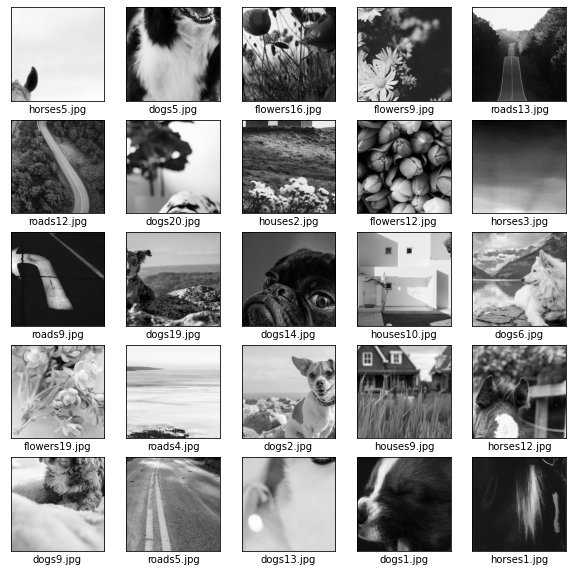

In [10]:
plt.figure(figsize=(10,10))
for i in range(25):
    src_image = src_patches[i,:,:]
    src_image = np.squeeze(src_image)
    plt.subplot(5,5,i+1)

    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(src_image, cmap='gray')
    plt.xlabel(fnames[i])
plt.show()

Add **Gaussian** **noise** for generating the **input**

In [11]:
noisy_src_patches=[]
noisy_src_patches = src_patches + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=src_patches.shape)
noisy_src_patches = np.clip(noisy_src_patches, 0., 1.)
print(noisy_src_patches.shape )

(100, 256, 256, 1)


Plot noisy patches

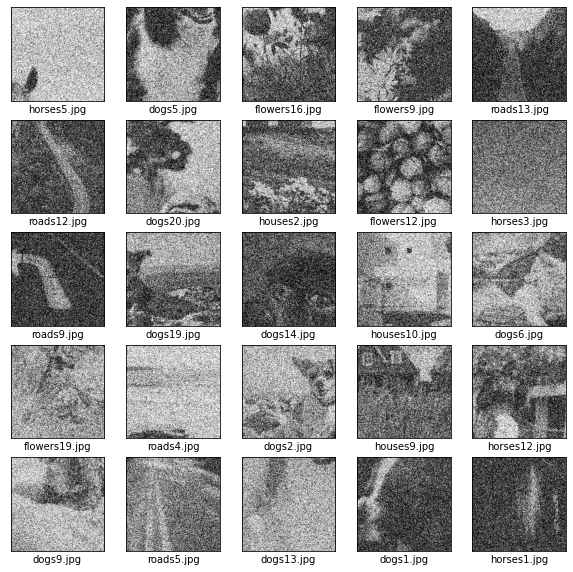

In [12]:
plt.figure(figsize=(10,10))
for i in range(25):
    noisy_src_image = noisy_src_patches[i,:,:]
    noisy_src_image = np.squeeze(noisy_src_image)
    plt.subplot(5,5,i+1)

    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(noisy_src_image, cmap='gray')
    plt.xlabel(fnames[i])
plt.show()

# Split into training and testing Datasets

In [0]:
# Execute to select randomly train and test
#X_train, X_test, y_train, y_test = train_test_split(noisy_src_patches, src_patches, test_size=0.2, random_state=5) 

In [14]:
split_patches= int(training_portion*(src_patches.shape[0]))
print('Number of train patches: ', split_patches)
print('Number of test patches: ', len(src_patches)-split_patches)


original_train_patches=src_patches[:split_patches, :, :, :]
#print('Original train patches: ', original_train_patches.shape)
noisy_train_patches= noisy_src_patches[:split_patches, :, :, :]
#print('Noisy train patches: ', noisy_train_patches.shape)

original_test_patches=src_patches[split_patches:, :, :, :]
#print('Original test patches: ', original_test_patches.shape)
noisy_test_patches= noisy_src_patches[split_patches:, :, :, :]
#print('Noisy test patches: ',noisy_test_patches.shape)

#Split filenames
train_fnames=fnames[:split_patches]
test_fnames=fnames[split_patches:]

Number of train patches:  80
Number of test patches:  20


# Defining a Sequential Model using Convolutional Neural Network (CNN)

In [15]:
'''
def define_model():
   cnn_model = Sequential([
    Conv2D(128, (3,3), padding='same', activation='relu',input_shape=(img_width, img_height,1)),
    Conv2D(64, (3,3), padding='same', activation='relu'),
    Conv2D(32, (3,3), padding='same', activation='relu'),

    Conv2DTranspose(32, (3,3), padding='same', activation='relu'),
    Conv2DTranspose(64, (3,3), padding='same', activation='relu'),
    Conv2DTranspose(128, (3,3), padding='same', activation='relu'),

    Conv2D(1, (3,3), padding='same', activation='sigmoid')
    ])
   return cnn_model
'''



"\ndef define_model():\n   cnn_model = Sequential([\n    Conv2D(128, (3,3), padding='same', activation='relu',input_shape=(img_width, img_height,1)),\n    Conv2D(64, (3,3), padding='same', activation='relu'),\n    Conv2D(32, (3,3), padding='same', activation='relu'),\n\n    Conv2DTranspose(32, (3,3), padding='same', activation='relu'),\n    Conv2DTranspose(64, (3,3), padding='same', activation='relu'),\n    Conv2DTranspose(128, (3,3), padding='same', activation='relu'),\n\n    Conv2D(1, (3,3), padding='same', activation='sigmoid')\n    ])\n   return cnn_model\n"

In [0]:
def define_model():
   cnn_model = Sequential([
    Conv2D(32, (3,3), padding='same', activation='relu',input_shape=(img_width, img_height,1)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), padding='same', activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), padding='same', activation='relu'),

    Conv2D(128, (3,3), padding='same', activation='relu'),
    UpSampling2D((2,2)),
    Conv2D(64, (3,3), padding='same', activation='relu'),
    UpSampling2D((2,2)),
    Conv2D(1, (3,3), padding='same', activation='sigmoid')
    ])
   return cnn_model

In [17]:
# Display the architecture of our model
model=define_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 128)       147584    
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 128, 128, 128)     0

### Tuning the hyper-parameters

 We do some basic hyper parameter tuning to pick a good learning rate for the gradient descent that will help to improve our model.

In [18]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.Adam(lr=1e-5)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(noisy_train_patches,
    original_train_patches,
    epochs=num_epochs, validation_split=0.2,
    batch_size=batch_size,
    callbacks=[lr_schedule], verbose=1)

Epoch 1/100
4/4 [==============================] - 1s 201ms/step - loss: 0.0728 - val_loss: 0.0696 - lr: 1.0000e-05
Epoch 2/100
4/4 [==============================] - 0s 55ms/step - loss: 0.0790 - val_loss: 0.0693 - lr: 1.1220e-05
Epoch 3/100
4/4 [==============================] - 0s 56ms/step - loss: 0.0776 - val_loss: 0.0690 - lr: 1.2589e-05
Epoch 4/100
4/4 [==============================] - 0s 53ms/step - loss: 0.0755 - val_loss: 0.0687 - lr: 1.4125e-05
Epoch 5/100
4/4 [==============================] - 0s 54ms/step - loss: 0.0773 - val_loss: 0.0683 - lr: 1.5849e-05
Epoch 6/100
4/4 [==============================] - 0s 54ms/step - loss: 0.0688 - val_loss: 0.0678 - lr: 1.7783e-05
Epoch 7/100
4/4 [==============================] - 0s 54ms/step - loss: 0.0701 - val_loss: 0.0672 - lr: 1.9953e-05
Epoch 8/100
4/4 [==============================] - 0s 56ms/step - loss: 0.0728 - val_loss: 0.0663 - lr: 2.2387e-05
Epoch 9/100
4/4 [==============================] - 0s 57ms/step - loss: 0.0733 

Text(0.5, 0, 'Learning Rate')

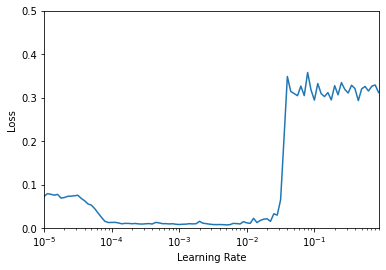

In [19]:
lrs = 1e-5 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-5,.9, 0, .5])
plt.ylabel('Loss')
plt.xlabel('Learning Rate')

We can  inspect the lower part of the curve before it gets unstable.
It comes to be 1e-3. We will set the learning rate to be 1e-3 and will compile and train our model in the next steps.


#### Compile and train the model

In [20]:
model=define_model()
optimizer = tf.keras.optimizers.Adam(lr=1e-3)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(noisy_train_patches,
    original_train_patches,
     validation_split=0.2,
    batch_size=batch_size,
    epochs=num_epochs, verbose=1)

Epoch 1/100
4/4 [==============================] - 0s 76ms/step - loss: 0.0657 - val_loss: 0.0869
Epoch 2/100
4/4 [==============================] - 0s 54ms/step - loss: 0.0607 - val_loss: 0.0290
Epoch 3/100
4/4 [==============================] - 0s 54ms/step - loss: 0.0344 - val_loss: 0.0260
Epoch 4/100
4/4 [==============================] - 0s 55ms/step - loss: 0.0234 - val_loss: 0.0162
Epoch 5/100
4/4 [==============================] - 0s 54ms/step - loss: 0.0175 - val_loss: 0.0174
Epoch 6/100
4/4 [==============================] - 0s 55ms/step - loss: 0.0150 - val_loss: 0.0123
Epoch 7/100
4/4 [==============================] - 0s 53ms/step - loss: 0.0130 - val_loss: 0.0116
Epoch 8/100
4/4 [==============================] - 0s 89ms/step - loss: 0.0122 - val_loss: 0.0113
Epoch 9/100
4/4 [==============================] - 0s 53ms/step - loss: 0.0110 - val_loss: 0.0105
Epoch 10/100
4/4 [==============================] - 0s 55ms/step - loss: 0.0100 - val_loss: 0.0104
Epoch 11/100
4/4 [=

## Evaluate the model

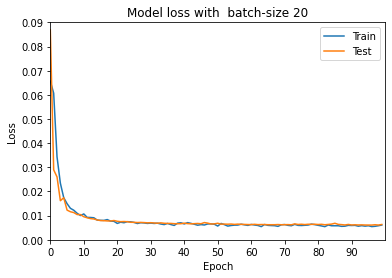

Train Loss: 0.0061, Test Loss: 0.0062


In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss with  batch-size 20')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.axis([0,100, 0, 0.09])
plt.xticks(np.arange(0, num_epochs, 10))
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

train_loss = model.evaluate(noisy_train_patches,  original_train_patches,verbose=0)
test_loss = model.evaluate(noisy_test_patches,  original_test_patches,verbose=0)
print('Train Loss: %.4f, Test Loss: %.4f' % (train_loss, test_loss))

Our training and testing loss seems pretty good.

### Zooming into the Loss vs Epoch

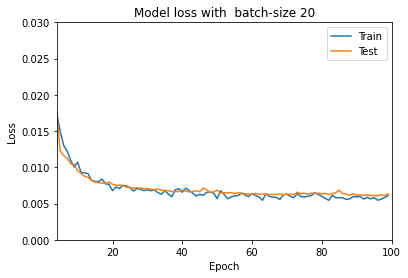

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss with  batch-size 20')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.axis([4,100, 0, 0.03])
#plt.xticks(np.arange(0, num_epochs, 10))
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()


We can see that loss function  fell sharply only after three epochs and then flattened out.

So we removed the first three  epochs and can see clearly that the loss is smoothly decreasing at 100 epochs.